In [1]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
import unicodedata
import nltk

import os
import time
import re

import acquire
import prepare

# imports for visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm # for colormap tools
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-whitegrid')
sns.set_palette('twilight')
sns.color_palette("cubehelix", as_cmap=True)
plt.rc('font', size=16)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Acquire

Pull cleaned, and prepped data saved to csv

In [2]:
# use csv cereated by team
df = pd.read_csv('NLP.csv')
df.drop(columns = 'Unnamed: 0', inplace=True)
df.sample(5)

,repo,language,readme_contents,clean,stemmed,lemmatized
139,MoveAngel/One4uBot,Python,"# One4uBot userbot project\n\n<p align=""center...",one4ubot userbot project p aligncenter hrefhtt...,one4ubot userbot project p aligncent hrefhttps...,one4ubot userbot project p aligncent hrefhttps...
220,VeNoMouS/cloudscraper,Python,# cloudscraper\n\n[![PyPI version](https://bad...,cloudscraper pypi versionhttpsbadgefuryiopyclo...,cloudscrap pypi versionhttpsbadgefuryiopycloud...,cloudscrap pypi versionhttpsbadgefuryiopycloud...
135,Gravebot/Gravebot,JavaScript,# Gravebot\n\n[![Build Status](https://david-d...,gravebot build statushttpsdaviddmorggravebotgr...,gravebot build statushttpsdaviddmorggravebotgr...,gravebot build statushttpsdaviddmorggravebotgr...
91,lionheart/bottlenose,Python,<!--\nCopyright 2012-2018 Lionheart Software L...,copyright 20122018 lionheart software llc lice...,copyright 20122018 lionheart softwar llc licen...,copyright 20122018 lionheart softwar llc licen...
112,jagrit007/Telegram-CloneBot,Python,# Why?\nFor all my friends using my TDs who no...,friends using tds need store everything instea...,friend use td need store everyth instead drive...,friend use td need store everyth instead drive...


# Feature enginieer 

In [3]:
# create column with count of characters in clean message
df['character_count'] = df.clean.str.len()
# create column with count of worlds in clean message
df['word_count'] =  df.clean.str.count(' ').add(1)

# create column with count of worlds in clean message
df['stemmed_word_count'] =  df.stemmed.str.count(' ').add(1)
df['lemmatized_word_count'] =  df.lemmatized.str.count(' ').add(1)

In [4]:
# count the records that have a ddiffernece in word count of stemmed vs lemmatized
(df.stemmed_word_count != df.lemmatized_word_count).sum()

3

In [5]:
df.sample()

,repo,language,readme_contents,clean,stemmed,lemmatized,character_count,word_count,stemmed_word_count,lemmatized_word_count
79,FeezyHendrix/Insta-mass-account-creator,Python,# Insta Mass Account creator (Not being mainta...,insta mass account creator maintained feel fre...,insta mass account creator maintain feel free ...,insta mass account creator maintain feel free ...,1492.0,171.0,171.0,171.0


In [6]:
df = df.drop(columns=['stemmed_word_count', 'lemmatized_word_count'])

# Takeaway 
- There is no significant difference in the word count of stemmed vs lemmatized
    - drop newly created columns
-------------

# Exploration


In [16]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "language")

,n,percent
Python,112,0.491228
JavaScript,55,0.241228
Java,24,0.105263
C#,20,0.087719
TypeScript,17,0.074561


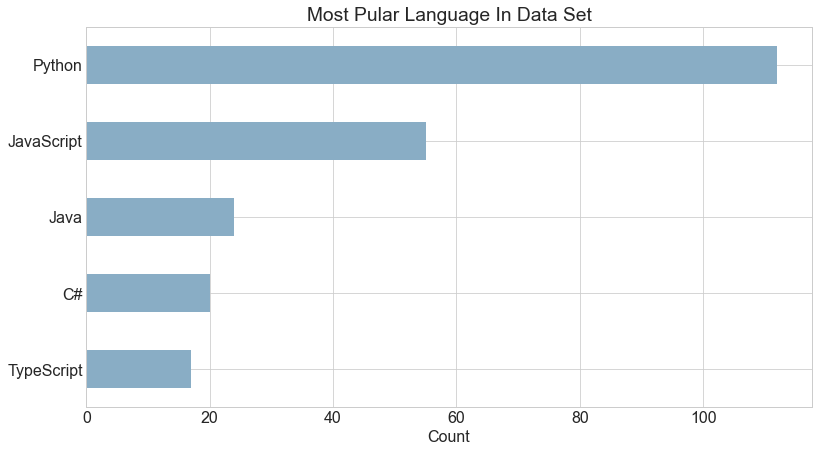

In [7]:
# create bar graph withthe count of lenguages of datafreame 
df.language.value_counts().sort_values(ascending = True).plot.barh()
plt.title('Most Pular Language In Data Set')
plt.xlabel("Count")
plt.show()

In [8]:
# create a df with language information based on character_count
message_length_info_df = df[['language','character_count']].\
                            groupby('language').agg(['mean', 'min', 'max', 'std' ])
message_length_info_df

character_count                             
                      mean    min      max          std
language                                               
C#             4158.578947   40.0  18281.0  5111.060450
Java           3890.708333  262.0  11377.0  2839.754880
JavaScript     3816.000000   40.0  20216.0  3981.926441
Python         3135.281818   46.0  17962.0  3388.263657
TypeScript     2892.823529   51.0  10180.0  2773.385504

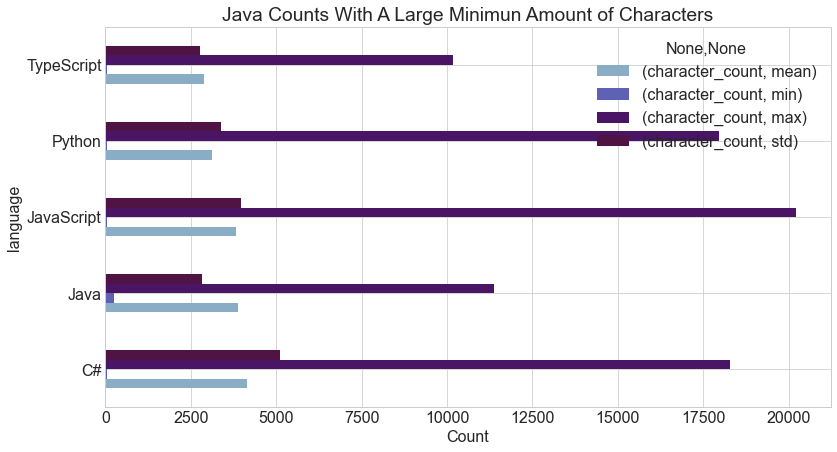

In [9]:
# creaet bar plot for  message_lenth_info_df 
message_length_info_df.plot.barh()
plt.title('Java Counts With A Large Minimun Amount of Characters')
plt.xlabel("Count")
plt.show()

In [10]:
# create a df with language information based on word_count
word_count_info_df = df[['language','word_count']].\
                        groupby('language').agg(['mean', 'min', 'max', 'std' ])
word_count_info_df

word_count                          
                  mean   min     max         std
language                                        
C#          313.263158   5.0  1282.0  296.985754
Java        340.875000  25.0   904.0  243.145030
JavaScript  398.890909   5.0  2376.0  414.738457
Python      339.090909   4.0  2058.0  388.835277
TypeScript  255.470588   7.0   831.0  220.717047

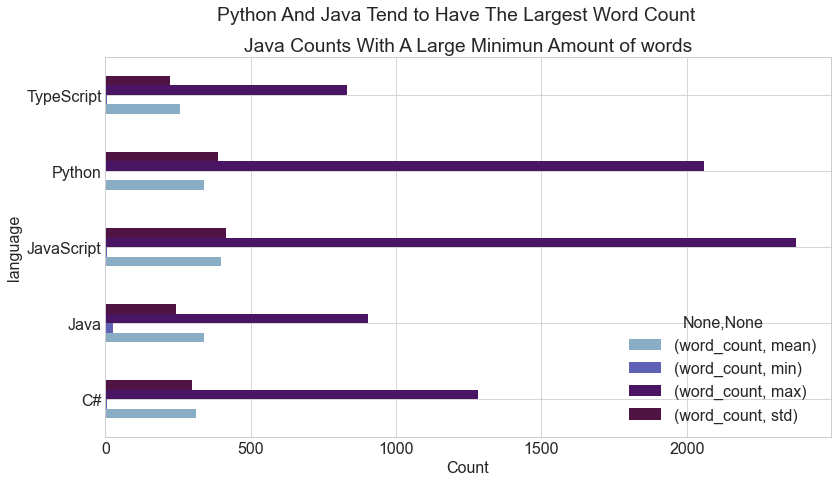

In [11]:
word_count_info_df.plot.barh()
plt.title('Java Counts With A Large Minimun Amount of words')
plt.suptitle('Python And Java Tend to Have The Largest Word Count')
plt.xlabel("Count")
plt.show()

# Takeaway
- TypeScript has the lowest standar diviation of charaters and word counts 
- JavaScrip has the largest average word count and secong largest mean for characters 
- Java has a large min amount of characters and word counts 
-
-


------------------------

In [12]:
train, validate, test = prepare.split_data(df)

In [13]:
print ('train    ===>', train.shape)
print ('validate ===>', validate.shape)
print('test      ===>', validate.shape)

train    ===> (127, 8)
validate ===> (55, 8)
test      ===> (55, 8)


In [14]:
test

,repo,language,readme_contents,clean,stemmed,lemmatized,character_count,word_count
160,theriley106/SneakerBotTutorials,Python,[![N|Solid](static/yeezy.jpg)](#)\n\n# **REVAM...,nsolidstaticyeezyjpg revamping sneaker bot upd...,nsolidstaticyeezyjpg revamp sneaker bot updat ...,nsolidstaticyeezyjpg revamp sneaker bot updat ...,846.0,83.0
178,CodeWithJoe2020/pancakeswapBot,Python,# pancakeswapBot\npython script to buy token f...,pancakeswapbot python script buy token pancake...,pancakeswapbot python script buy token pancake...,pancakeswapbot python script buy token pancake...,190.0,17.0
130,xHak9x/fbi,Python,\n\n```\n\t\t\t\t ________. .__ \n\t\t\t ...,&#9; &#9; &#9; &#9; ________ __ &#9; &#9; &#9;...,&#9; &#9; &#9; &#9; ________ __ &#9; &#9; &#9;...,&#9; &#9; &#9; &#9; ________ __ &#9; &#9; &#9;...,808.0,104.0
151,meepen/salien-bot,JavaScript,# Salien Bot\n\nSalien Bot is a WIP bot for th...,salien bot salien bot wip bot salien minigame ...,salien bot salien bot wip bot salien minigam c...,salien bot salien bot wip bot salien minigam c...,1968.0,246.0
80,adonespitogo/AdoBot,Java,# AdoBot\n\nOpensource Android Spyware\n\n# Fe...,adobot opensource android spyware features rea...,adobot opensourc android spywar featur realtim...,adobot opensourc android spywar featur realtim...,1923.0,229.0
141,michaelbel/BottomSheet,Java,[apk-url]: https://github.com/michael...,apkurl httpsgithubcommichaelbelbottomsheetrawm...,apkurl httpsgithubcommichaelbelbottomsheetrawm...,apkurl httpsgithubcommichaelbelbottomsheetrawm...,4659.0,296.0
140,BeepIsla/csgo-commend-bot,JavaScript,# CSGO Commend Bot\nAllows you to send commend...,csgo commend bot allows send commends reports ...,csgo commend bot allow send commend report csg...,csgo commend bot allow send commend report csg...,8202.0,1062.0
79,FeezyHendrix/Insta-mass-account-creator,Python,# Insta Mass Account creator (Not being mainta...,insta mass account creator maintained feel fre...,insta mass account creator maintain feel free ...,insta mass account creator maintain feel free ...,1492.0,171.0
197,dtcarls/fantasy_football_chat_bot,Python,[![GitHub release](https://img.shields.io/gith...,github releasehttpsimgshieldsiogithubvreleased...,github releasehttpsimgshieldsiogithubvreleased...,github releasehttpsimgshieldsiogithubvreleased...,10977.0,1252.0
20,Just-Some-Bots/MusicBot,Python,# MusicBot\n\n[![GitHub stars](https://img.shi...,musicbot github starshttpsimgshieldsiogithubst...,musicbot github starshttpsimgshieldsiogithubst...,musicbot github starshttpsimgshieldsiogithubst...,1461.0,122.0
